# Import

In [1]:
# Basic
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter('ignore')

# ML Toolkit
from robusta.crossval import *
from robusta.selector import *
from robusta.pipeline import *
from robusta.preprocessing import *

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import *

# Model
from sklearn.linear_model import Ridge

# Plot
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib

jtplot.style('gruvboxd')
matplotlib.use('nbagg')

Using TensorFlow backend.


# Data

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=200, n_features=50, n_informative=5, 
                       random_state=666)

X = pd.DataFrame(X)
y = pd.Series(y)

X.rename(columns=lambda x: 'x{}'.format(x), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Task & Model

In [3]:
get_score = lambda y_true, y_pred: -mean_squared_error(y_true, y_pred)
scoring = 'neg_mean_squared_error'

cv = 5

model = Ridge()

# Baseline

In [4]:
_, y_pred = crossval_predict(model, cv, X_train, y_train, X_new=X_test,
                             scoring=scoring, verbose=2, n_jobs=None)

get_score(y_test, y_pred)

[18:36:26]  Ridge

[18:36:26]  FOLD  0:   -6.8685
[18:36:26]  FOLD  1:   -8.7267
[18:36:26]  FOLD  2:   -10.6242
[18:36:26]  FOLD  3:   -20.1918
[18:36:26]  FOLD  4:   -13.1002

[18:36:27]  AVERAGE:   -11.9023 ± 4.6305



-9.600466067788235

# Differential Evolution

In [5]:
selector = GeneticSelector(model, cv, scoring, crossover=0.3, max_iter=1000)
selector.fit(X_train, y_train)

[18:36:27] GENERATION 1
[18:36:27] ITER: 1/1000      SUBSET: 22/50      SCORE: -22397.7862 ± 4093.9238      ETA: 19 sec
[18:36:27] ITER: 2/1000      SUBSET: 27/50      SCORE: -15974.8597 ± 3944.3253      ETA: 19 sec
[18:36:27] ITER: 3/1000      SUBSET: 24/50      SCORE: -15011.7332 ± 3584.3023      ETA: 20 sec
[18:36:27] ITER: 4/1000      SUBSET: 26/50      SCORE: -4.8616 ± 1.1216      ETA: 22 sec
[18:36:27] ITER: 5/1000      SUBSET: 28/50      SCORE: -10844.5973 ± 2456.7497      ETA: 21 sec
[18:36:27] ITER: 6/1000      SUBSET: 29/50      SCORE: -2252.8008 ± 338.5422      ETA: 22 sec
[18:36:27] ITER: 7/1000      SUBSET: 20/50      SCORE: -14169.9699 ± 2724.0249      ETA: 22 sec
[18:36:27] ITER: 8/1000      SUBSET: 27/50      SCORE: -5363.7916 ± 1344.2111      ETA: 22 sec
[18:36:27] ITER: 9/1000      SUBSET: 30/50      SCORE: -6258.2983 ± 1883.6073      ETA: 22 sec
[18:36:27] ITER: 10/1000      SUBSET: 24/50      SCORE: -7288.1378 ± 1843.8312      ETA: 22 sec
[18:36:27] ITER: 11/1000   

[18:36:30] ITER: 87/1000      SUBSET: 21/50      SCORE: -3.7792 ± 1.2081      ETA: 18 sec
[18:36:30] ITER: 88/1000      SUBSET: 20/50      SCORE: -3.8115 ± 0.8891      ETA: 18 sec
[18:36:30] ITER: 89/1000      SUBSET: 21/50      SCORE: -3.8528 ± 1.2143      ETA: 18 sec
[18:36:30] ITER: 90/1000      SUBSET: 21/50      SCORE: -3.7897 ± 0.7653      ETA: 18 sec
[18:36:30] ITER: 91/1000      SUBSET: 20/50      SCORE: -3.8749 ± 1.0954      ETA: 18 sec
[18:36:30] GENERATION 10
[18:36:30] ITER: 92/1000      SUBSET: 22/50      SCORE: -3.7599 ± 1.0006      ETA: 18 sec
[18:36:30] ITER: 93/1000      SUBSET: 22/50      SCORE: -3.8115 ± 0.9742      ETA: 18 sec
[18:36:30] ITER: 94/1000      SUBSET: 21/50      SCORE: -3.7577 ± 0.9644      ETA: 18 sec
[18:36:30] ITER: 95/1000      SUBSET: 22/50      SCORE: -3.7824 ± 0.8554      ETA: 18 sec
[18:36:30] ITER: 96/1000      SUBSET: 21/50      SCORE: -3.7792 ± 1.2081      ETA: 18 sec
[18:36:30] ITER: 97/1000      SUBSET: 20/50      SCORE: -3.8659 ± 1.2723   

[18:36:33] ITER: 177/1000      SUBSET: 18/50      SCORE: -3.5057 ± 0.6899      ETA: 16 sec
[18:36:33] ITER: 178/1000      SUBSET: 16/50      SCORE: -3.3562 ± 0.7919      ETA: 16 sec
[18:36:33] ITER: 179/1000      SUBSET: 16/50      SCORE: -3.3562 ± 0.7919      ETA: 16 sec
[18:36:33] ITER: 180/1000      SUBSET: 17/50      SCORE: -3.4015 ± 0.7269      ETA: 16 sec
[18:36:33] ITER: 181/1000      SUBSET: 16/50      SCORE: -3.3562 ± 0.7919      ETA: 16 sec
[18:36:33] ITER: 182/1000      SUBSET: 16/50      SCORE: -3.3562 ± 0.7919      ETA: 16 sec
[18:36:33] ITER: 183/1000      SUBSET: 16/50      SCORE: -3.3562 ± 0.7919      ETA: 16 sec
[18:36:33] ITER: 184/1000      SUBSET: 16/50      SCORE: -3.3562 ± 0.7919      ETA: 16 sec
[18:36:33] ITER: 185/1000      SUBSET: 16/50      SCORE: -3.3562 ± 0.7919      ETA: 16 sec
[18:36:33] GENERATION 24
[18:36:33] ITER: 186/1000      SUBSET: 16/50      SCORE: -3.3562 ± 0.7919      ETA: 16 sec
[18:36:33] ITER: 187/1000      SUBSET: 16/50      SCORE: -3.3562 

[18:36:36] ITER: 267/1000      SUBSET: 15/50      SCORE: -3.2750 ± 0.8857      ETA: 14 sec
[18:36:36] ITER: 268/1000      SUBSET: 15/50      SCORE: -3.2783 ± 0.8049      ETA: 14 sec
[18:36:36] ITER: 269/1000      SUBSET: 15/50      SCORE: -3.2870 ± 0.8008      ETA: 14 sec
[18:36:36] GENERATION 36
[18:36:36] ITER: 270/1000      SUBSET: 14/50      SCORE: -3.1954 ± 0.8165      ETA: 14 sec
[18:36:36] ITER: 271/1000      SUBSET: 15/50      SCORE: -3.2273 ± 0.8052      ETA: 14 sec
[18:36:36] ITER: 272/1000      SUBSET: 15/50      SCORE: -3.4251 ± 0.9618      ETA: 14 sec
[18:36:36] ITER: 273/1000      SUBSET: 14/50      SCORE: -3.2438 ± 0.7573      ETA: 14 sec
[18:36:36] ITER: 274/1000      SUBSET: 16/50      SCORE: -3.3196 ± 0.9481      ETA: 14 sec
[18:36:36] ITER: 275/1000      SUBSET: 15/50      SCORE: -3.2273 ± 0.8052      ETA: 14 sec
[18:36:36] ITER: 276/1000      SUBSET: 14/50      SCORE: -3.1954 ± 0.8165      ETA: 14 sec
[18:36:36] ITER: 277/1000      SUBSET: 14/50      SCORE: -3.1954 

[18:36:39] ITER: 359/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 12 sec
[18:36:39] ITER: 360/1000      SUBSET: 15/50      SCORE: -3.4214 ± 0.7100      ETA: 12 sec
[18:36:39] ITER: 361/1000      SUBSET: 12/50      SCORE: -3.0653 ± 0.8470      ETA: 12 sec
[18:36:39] ITER: 362/1000      SUBSET: 12/50      SCORE: -3.0653 ± 0.8470      ETA: 12 sec
[18:36:39] ITER: 363/1000      SUBSET: 12/50      SCORE: -3.0653 ± 0.8470      ETA: 12 sec
[18:36:39] GENERATION 45
[18:36:39] ITER: 364/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 12 sec
[18:36:39] ITER: 365/1000      SUBSET: 14/50      SCORE: -3.2400 ± 0.8595      ETA: 12 sec
[18:36:39] ITER: 366/1000      SUBSET: 13/50      SCORE: -4423.3267 ± 567.7036      ETA: 12 sec
[18:36:39] ITER: 367/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 12 sec
[18:36:39] ITER: 368/1000      SUBSET: 12/50      SCORE: -3.0653 ± 0.8470      ETA: 12 sec
[18:36:39] ITER: 369/1000      SUBSET: 11/50      SCORE: -3.

[18:36:42] ITER: 451/1000      SUBSET: 10/50      SCORE: -1797.2635 ± 87.8188      ETA: 10 sec
[18:36:42] ITER: 452/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 10 sec
[18:36:42] ITER: 453/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 10 sec
[18:36:42] ITER: 454/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 10 sec
[18:36:42] GENERATION 56
[18:36:42] ITER: 455/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 10 sec
[18:36:42] ITER: 456/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 10 sec
[18:36:42] ITER: 457/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 10 sec
[18:36:42] ITER: 458/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 10 sec
[18:36:42] GENERATION 57
[18:36:42] ITER: 459/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 10 sec
[18:36:42] ITER: 460/1000      SUBSET: 11/50      SCORE: -3.0461 ± 0.8533      ETA: 10 sec
[18:36:42] ITER: 461/1000      SUBSE

[18:36:45] ITER: 543/1000      SUBSET: 11/50      SCORE: -3.0378 ± 0.7701      ETA: 9 sec
[18:36:45] ITER: 544/1000      SUBSET: 11/50      SCORE: -3.0378 ± 0.7701      ETA: 9 sec
[18:36:45] GENERATION 69
[18:36:45] ITER: 545/1000      SUBSET: 11/50      SCORE: -3.0378 ± 0.7701      ETA: 9 sec
[18:36:45] ITER: 546/1000      SUBSET: 11/50      SCORE: -3.0378 ± 0.7701      ETA: 9 sec
[18:36:45] ITER: 547/1000      SUBSET: 11/50      SCORE: -3.0378 ± 0.7701      ETA: 8 sec
[18:36:45] ITER: 548/1000      SUBSET: 11/50      SCORE: -3.0378 ± 0.7701      ETA: 8 sec
[18:36:45] ITER: 549/1000      SUBSET: 14/50      SCORE: -3.2532 ± 0.7042      ETA: 8 sec
[18:36:45] ITER: 550/1000      SUBSET: 13/50      SCORE: -3.1890 ± 0.8150      ETA: 8 sec
[18:36:45] ITER: 551/1000      SUBSET: 14/50      SCORE: -3.4167 ± 0.7741      ETA: 8 sec
[18:36:45] GENERATION 70
[18:36:45] ITER: 552/1000      SUBSET: 11/50      SCORE: -3.0378 ± 0.7701      ETA: 8 sec
[18:36:45] ITER: 553/1000      SUBSET: 11/50      

[18:36:48] ITER: 633/1000      SUBSET: 10/50      SCORE: -2.9458 ± 0.7223      ETA: 7 sec
[18:36:48] ITER: 634/1000      SUBSET: 12/50      SCORE: -3.1070 ± 0.7942      ETA: 7 sec
[18:36:48] ITER: 635/1000      SUBSET: 11/50      SCORE: -3.0378 ± 0.7701      ETA: 7 sec
[18:36:48] ITER: 636/1000      SUBSET: 15/50      SCORE: -1731.7365 ± 287.4194      ETA: 7 sec
[18:36:48] ITER: 637/1000      SUBSET: 12/50      SCORE: -3.1070 ± 0.7942      ETA: 7 sec
[18:36:48] ITER: 638/1000      SUBSET: 10/50      SCORE: -2.9458 ± 0.7223      ETA: 7 sec
[18:36:48] GENERATION 82
[18:36:48] ITER: 639/1000      SUBSET: 10/50      SCORE: -2.9458 ± 0.7223      ETA: 7 sec
[18:36:48] ITER: 640/1000      SUBSET: 10/50      SCORE: -2.9458 ± 0.7223      ETA: 7 sec
[18:36:48] ITER: 641/1000      SUBSET: 10/50      SCORE: -2.9458 ± 0.7223      ETA: 7 sec
[18:36:48] ITER: 642/1000      SUBSET: 13/50      SCORE: -3.2646 ± 0.6222      ETA: 7 sec
[18:36:48] GENERATION 83
[18:36:48] ITER: 643/1000      SUBSET: 10/50 

[18:36:51] ITER: 724/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] ITER: 725/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] ITER: 726/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] ITER: 727/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] ITER: 728/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] ITER: 729/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] ITER: 730/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] ITER: 731/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] ITER: 732/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] GENERATION 97
[18:36:51] ITER: 733/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 sec
[18:36:51] ITER: 734/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 5 

[18:36:54] ITER: 816/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 3 sec
[18:36:54] ITER: 817/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 3 sec
[18:36:54] ITER: 818/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 3 sec
[18:36:54] GENERATION 110
[18:36:54] ITER: 819/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 3 sec
[18:36:54] ITER: 820/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 3 sec
[18:36:54] ITER: 821/1000      SUBSET: 9/50      SCORE: -6186.2369 ± 1601.2941      ETA: 3 sec
[18:36:54] ITER: 822/1000      SUBSET: 9/50      SCORE: -3.0488 ± 0.7690      ETA: 3 sec
[18:36:54] ITER: 823/1000      SUBSET: 10/50      SCORE: -3.0918 ± 0.7106      ETA: 3 sec
[18:36:54] ITER: 824/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 3 sec
[18:36:54] ITER: 825/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 3 sec
[18:36:54] GENERATION 111
[18:36:54] ITER: 826/1000      SUBSET: 9/50      SC

[18:36:57] ITER: 907/1000      SUBSET: 10/50      SCORE: -2.9045 ± 0.6698      ETA: 1 sec
[18:36:57] GENERATION 123
[18:36:57] ITER: 908/1000      SUBSET: 11/50      SCORE: -3.1042 ± 0.7846      ETA: 1 sec
[18:36:57] GENERATION 124
[18:36:57] ITER: 909/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 1 sec
[18:36:57] ITER: 910/1000      SUBSET: 10/50      SCORE: -3.0671 ± 0.7461      ETA: 1 sec
[18:36:57] ITER: 911/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 1 sec
[18:36:57] ITER: 912/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 1 sec
[18:36:57] ITER: 913/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 1 sec
[18:36:57] ITER: 914/1000      SUBSET: 11/50      SCORE: -6326.1713 ± 1169.2697      ETA: 1 sec
[18:36:57] ITER: 915/1000      SUBSET: 12/50      SCORE: -3.2820 ± 0.8392      ETA: 1 sec
[18:36:57] GENERATION 125
[18:36:57] ITER: 916/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 1 sec
[18:36:57] ITER: 917/

[18:37:00] ITER: 998/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 39 ms
[18:37:00] ITER: 999/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 19 ms
[18:37:00] ITER: 1000/1000      SUBSET: 9/50      SCORE: -2.8811 ± 0.6084      ETA: 0 ms
Iterations limit exceed!


GeneticSelector(crossover=0.3, cv=5,
                estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                max_iter=None, normalize=False,
                                random_state=None, solver='auto', tol=0.001),
                max_iter=1000, max_time=None, mut_freq=0.1, mut_prob=0.05,
                n_digits=4, n_jobs=None, pop_size=20, random_state=None,
                scoring='neg_mean_squared_error', verbose=1)

<IPython.core.display.Javascript object>


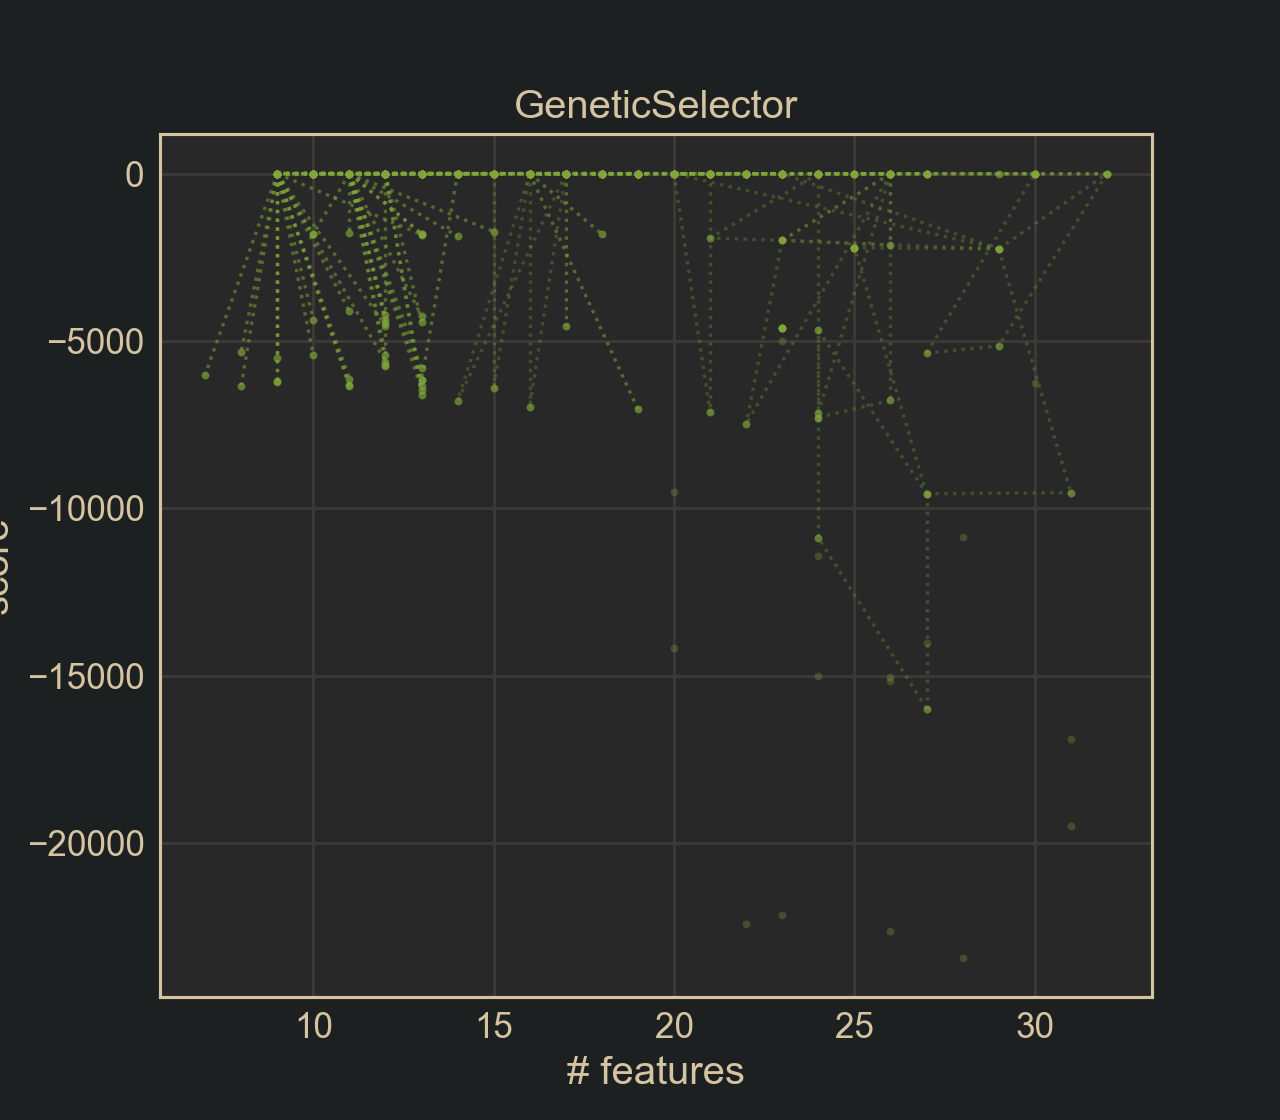

In [6]:
%matplotlib notebook

fig, ax = selector.plot(marker='.', color='g', linestyle=':', alpha=0.3)

<IPython.core.display.Javascript object>


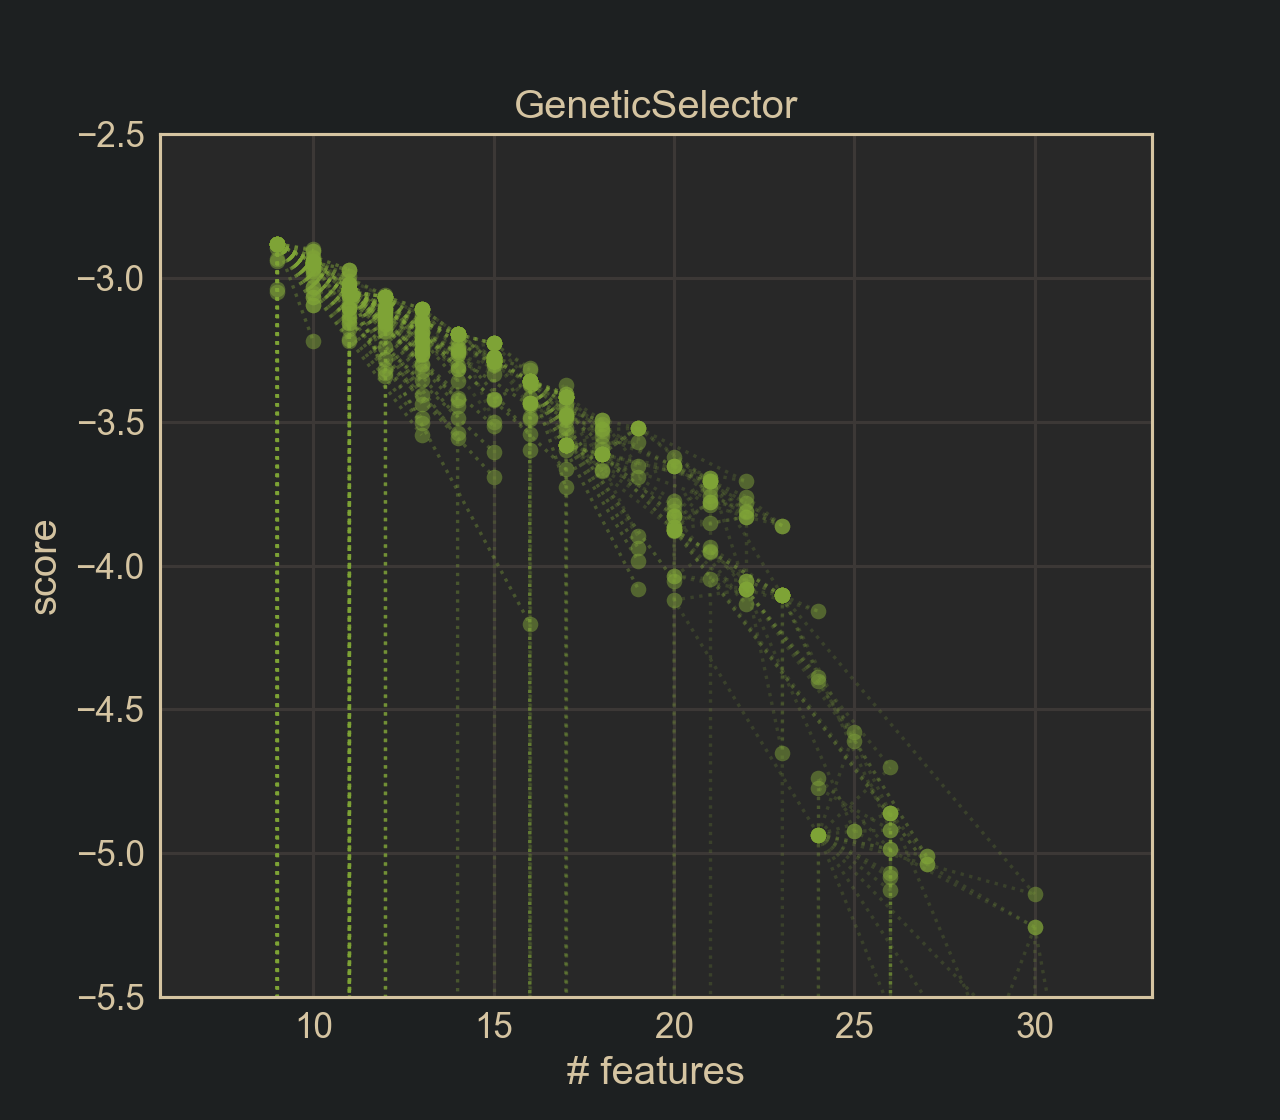

(-5.5, -2.5)

In [7]:
%matplotlib notebook

fig, ax = selector.plot(marker='o', color='g', linestyle=':', alpha=0.2)
ax.set_ylim([-5.5, -2.5])

In [8]:
X_train_ = selector.transform(X_train)
X_test_  = selector.transform(X_test)

_, y_pred = crossval_predict(model, cv, X_train_, y_train, X_new=X_test_,
                             scoring=scoring, verbose=2, n_jobs=-1)

get_score(y_test, y_pred)

[18:37:29]  Ridge

[18:37:30]  FOLD  0:   -2.7557
[18:37:30]  FOLD  1:   -2.9467
[18:37:30]  FOLD  2:   -2.1160
[18:37:30]  FOLD  3:   -3.9662
[18:37:30]  FOLD  4:   -2.6209

[18:37:30]  AVERAGE:   -2.8811 ± 0.6084



-3.4411632380229484

In [9]:
selector.get_subset()

FeatureSubset(['x19' 'x24' 'x25' 'x26' 'x28' 'x29' 'x31' 'x36' 'x44'])

# Differential Evolution (Group)

In [17]:
K = 3

FUNC = lambda i, k: lambda x: (i*k <= int(x[1:]) < i*k+k)
NAME = lambda i, k: 'x{}-x{}'.format(i*k, i*k+k-1)

prep_pipe = FeatureUnion([
    (NAME(i, K), make_pipeline(ColumnFilter(FUNC(i, K)), ColumnGrouper(NAME(i, K))))
    for i in range(X.shape[1] // K)
])

X_train_ = prep_pipe.fit_transform(X_train)
X_test_ = prep_pipe.transform(X_test)

X_train_

x0-x2                         x3-x5                         x6-x8  \
           x0        x1        x2        x3        x4        x5        x6   
114 -0.486192 -1.938886 -0.256917 -1.777999  0.247760 -0.595619 -0.039071   
173  0.748457  0.698708  1.189265 -0.599598  1.561570  1.308718  2.338996   
5   -0.467878  0.576009  1.022346  0.038953 -0.956788  0.224985 -1.821917   
126  0.211089  1.501854  0.340881  0.624708  0.411308  1.285594 -1.225613   
117 -0.064375  0.306493  0.444210  0.213568 -0.401956 -1.483166  1.678015   
..        ...       ...       ...       ...       ...       ...       ...   
106  0.616855  0.312075 -0.505777 -0.670151  0.747201  0.061859 -0.196145   
14   1.677128  1.597251 -0.197574 -0.428889 -0.626220 -0.118218 -1.853054   
92   1.319507 -0.374697  0.181910 -0.755100  0.749837  0.460237 -0.564057   
179  0.415623  1.316133 -1.388109  0.373652 -1.238512 -0.706704  0.962477   
102 -3.362675  0.483243 -1.490254 -0.423965 -0.426087 -0.421017  0.602901   

                           x9-x11  ...   x36-x38   x39-x41            \
           x7        x8        x9  ...       x38       x39       x40   
114 -0.222884  0.889465  0.404758  ... -0.458487 -2.165005 -0.089909   
173 -1.122985 -0.450689 -1.809998  ...  0.666394 -0.298129  0.092768   
5   -1.184674  0.065417 -0.364568  ... -1.108871  0.228600  0.819855   
126  1.748311 -0.018077  0.829071  ... -0.185490 -2.263209 -0.779928   
117  2.175929  1.754764  1.116414  ...  0.008828  0.124768 -0.425790   
..        ...       ...       ...  ...       ...       ...       ...   
106  0.398577  0.381527 -0.647369  ... -0.918174  0.649996 -1.607627   
14  -1.479926  1.178236  0.107689  ... -1.180548 -1.065820 -0.393123   
92  -0.185643 -0.502900 -1.192589  ...  0.647703 -1.771868  0.072571   
179 -1.459485 -1.157150 -1.330585  ... -0.156693  1.653879 -1.081663   
102  0.888508  0.210508  0.860256  ... -1.182391  0.432586 -0.737271   

                x42-x44                       x45-x47                      
          x41       x42       x43       x44       x45       x46       x47  
114 -1.854918  0.196557 -0.395199  0.778831  0.047767  2.023676  0.649204  
173 -1.244179 -0.505445 -0.330599  1.119375 -1.401945 -0.116295  0.896283  
5    1.121932 -0.050049 -1.537254 -0.643587  1.509838 -1.902997 -0.671284  
126  0.391001  0.271996 -1.327205 -2.629107  0.633351  1.212322 -0.327737  
117  0.102304  1.446403  1.979220  0.274520  1.395296  0.023173  0.097237  
..        ...       ...       ...       ...       ...       ...       ...  
106 -0.150597  1.899005 -1.792778 -0.802560  2.104725 -0.104431  1.252028  
14  -0.239452  1.538816 -0.736272  1.860053 -0.042949 -3.103916  0.516133  
92  -0.372955  0.240492  0.034488 -0.991030  0.258708  0.282763 -1.376814  
179  0.109985 -0.710280  0.918187 -0.430674 -0.099369 -0.201156 -2.586488  
102  0.354971  0.454211  1.589926  1.032257 -0.678496 -0.072822 -1.156053  

[150 rows x 48 columns]

In [18]:
selector = GroupGeneticSelector(model, cv, scoring, crossover=0.5,
                                max_iter=200, pop_size=10,
                                mut_freq=0.1, mut_prob=0.2)
selector.fit(X_train_, y_train)

[18:38:20] GENERATION 1
[18:38:20] ITER: 1/200      SUBSET: 5/16      SCORE: -21570.6746 ± 4416.2137      ETA: 3 sec
[18:38:20] ITER: 2/200      SUBSET: 9/16      SCORE: -17318.4379 ± 3679.9144      ETA: 4 sec
[18:38:20] ITER: 3/200      SUBSET: 11/16      SCORE: -27131.7602 ± 4870.7306      ETA: 4 sec
[18:38:20] ITER: 4/200      SUBSET: 3/16      SCORE: -13583.9096 ± 1636.9238      ETA: 4 sec
[18:38:20] ITER: 5/200      SUBSET: 6/16      SCORE: -17586.5998 ± 5796.4427      ETA: 3 sec
[18:38:20] ITER: 6/200      SUBSET: 9/16      SCORE: -14093.6057 ± 3455.1811      ETA: 3 sec
[18:38:20] ITER: 7/200      SUBSET: 6/16      SCORE: -22834.9810 ± 6288.5404      ETA: 4 sec
[18:38:20] ITER: 8/200      SUBSET: 8/16      SCORE: -14414.7070 ± 5664.7270      ETA: 4 sec
[18:38:20] ITER: 9/200      SUBSET: 7/16      SCORE: -23481.0718 ± 5181.3659      ETA: 4 sec
[18:38:20] ITER: 10/200      SUBSET: 8/16      SCORE: -13444.4646 ± 3855.6752      ETA: 4 sec
[18:38:20] GENERATION 2
[18:38:20] ITER: 11/

[18:38:23] ITER: 85/200      SUBSET: 7/16      SCORE: -4578.3705 ± 989.3878      ETA: 2 sec
[18:38:23] ITER: 86/200      SUBSET: 7/16      SCORE: -4578.3705 ± 989.3878      ETA: 2 sec
[18:38:23] ITER: 87/200      SUBSET: 7/16      SCORE: -4578.3705 ± 989.3878      ETA: 2 sec
[18:38:23] GENERATION 18
[18:38:23] ITER: 88/200      SUBSET: 7/16      SCORE: -4578.3705 ± 989.3878      ETA: 2 sec
[18:38:23] ITER: 89/200      SUBSET: 7/16      SCORE: -4578.3705 ± 989.3878      ETA: 2 sec
[18:38:23] ITER: 90/200      SUBSET: 7/16      SCORE: -4578.3705 ± 989.3878      ETA: 2 sec
[18:38:23] ITER: 91/200      SUBSET: 7/16      SCORE: -4578.3705 ± 989.3878      ETA: 2 sec
[18:38:23] GENERATION 19
[18:38:23] ITER: 92/200      SUBSET: 7/16      SCORE: -4578.3705 ± 989.3878      ETA: 2 sec
[18:38:23] ITER: 93/200      SUBSET: 7/16      SCORE: -4578.3705 ± 989.3878      ETA: 2 sec
[18:38:23] ITER: 94/200      SUBSET: 9/16      SCORE: -5.4227 ± 1.4148      ETA: 2 sec
[18:38:23] ITER: 95/200      SUBSET

[18:38:26] ITER: 171/200      SUBSET: 5/16      SCORE: -3.4885 ± 0.8885      ETA: 620 ms
[18:38:26] ITER: 172/200      SUBSET: 5/16      SCORE: -3.4885 ± 0.8885      ETA: 598 ms
[18:38:26] ITER: 173/200      SUBSET: 6/16      SCORE: -3.7931 ± 1.1779      ETA: 576 ms
[18:38:26] ITER: 174/200      SUBSET: 4/16      SCORE: -4235.8249 ± 533.6130      ETA: 555 ms
[18:38:26] ITER: 175/200      SUBSET: 5/16      SCORE: -3.4885 ± 0.8885      ETA: 534 ms
[18:38:26] GENERATION 35
[18:38:26] ITER: 176/200      SUBSET: 5/16      SCORE: -3.4885 ± 0.8885      ETA: 512 ms
[18:38:26] ITER: 177/200      SUBSET: 5/16      SCORE: -3.4885 ± 0.8885      ETA: 491 ms
[18:38:26] GENERATION 36
[18:38:26] ITER: 178/200      SUBSET: 5/16      SCORE: -3.4885 ± 0.8885      ETA: 469 ms
[18:38:26] ITER: 179/200      SUBSET: 5/16      SCORE: -3.4885 ± 0.8885      ETA: 448 ms
[18:38:26] ITER: 180/200      SUBSET: 5/16      SCORE: -3.4885 ± 0.8885      ETA: 427 ms
[18:38:26] ITER: 181/200      SUBSET: 5/16      SCORE: 

GroupGeneticSelector(crossover=0.5, cv=5,
                     estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False,
                                     random_state=None, solver='auto',
                                     tol=0.001),
                     max_iter=200, max_time=None, mut_freq=0.1, mut_prob=0.2,
                     n_digits=4, n_jobs=None, pop_size=10, random_state=None,
                     scoring='neg_mean_squared_error', verbose=1)

<IPython.core.display.Javascript object>


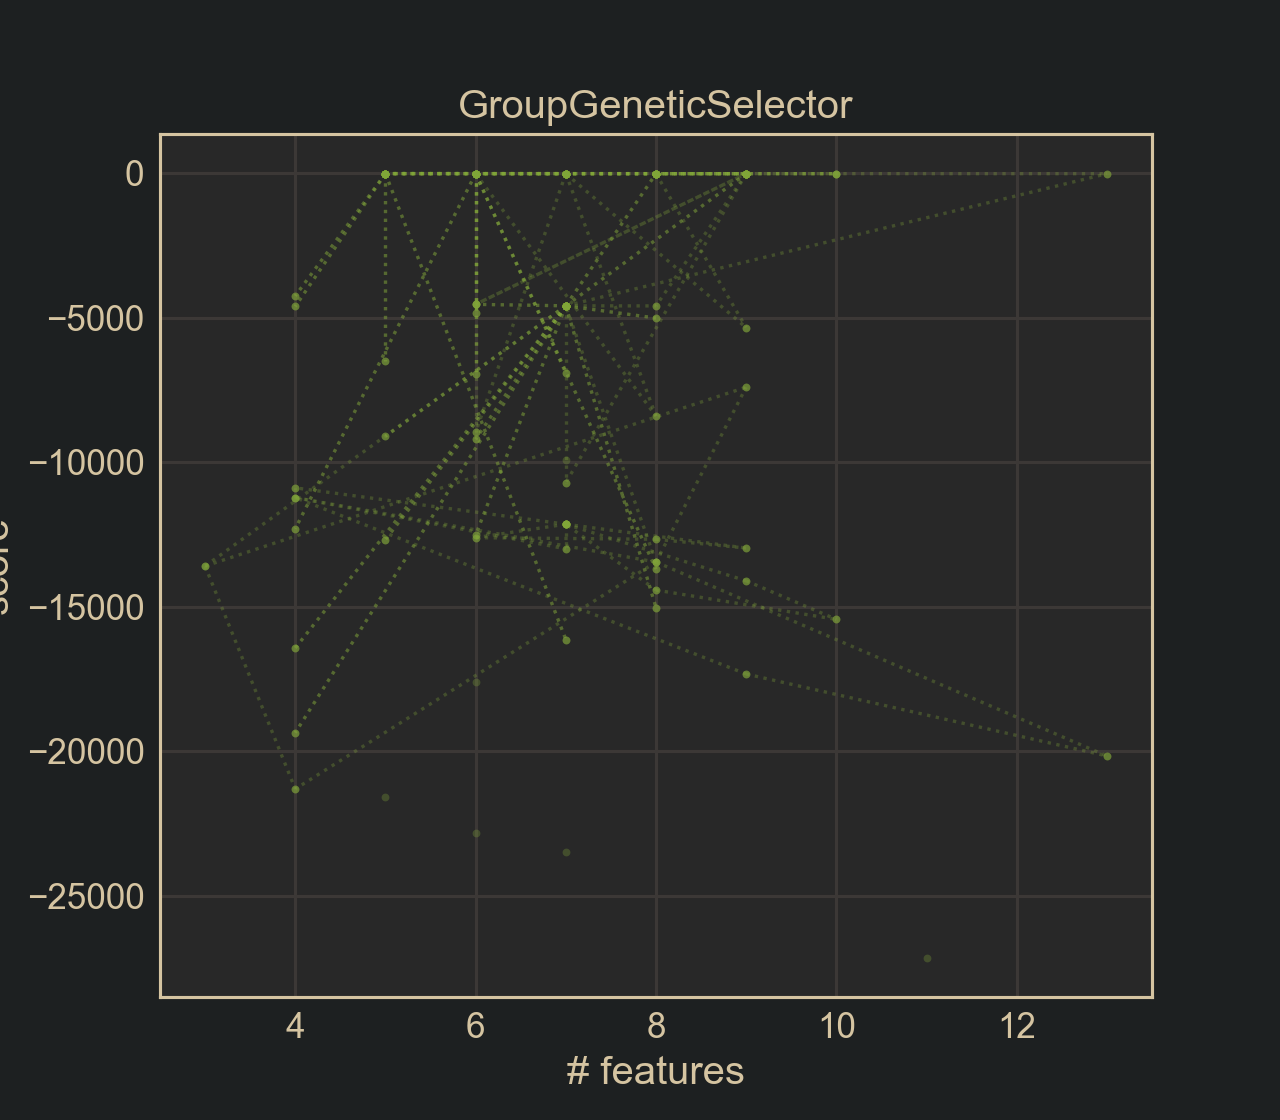

In [19]:
%matplotlib notebook

fig, ax = selector.plot(marker='.', color='g', linestyle=':', alpha=0.3)

In [20]:
subset = selector.get_subset()

_, y_pred = crossval_predict(model, cv, X_train_[subset], y_train, X_new=X_test_[subset],
                             scoring=scoring, verbose=2, n_jobs=-1)

get_score(y_test, y_pred)

[18:38:35]  Ridge

[18:38:35]  FOLD  0:   -2.8755
[18:38:35]  FOLD  1:   -3.5666
[18:38:35]  FOLD  2:   -2.7135
[18:38:35]  FOLD  3:   -5.1697
[18:38:35]  FOLD  4:   -3.1174

[18:38:35]  AVERAGE:   -3.4885 ± 0.8885



-3.7329884876220882

In [21]:
subset

FeatureSubset(Index(['x9-x11', 'x18-x20', 'x27-x29', 'x36-x38', 'x42-x44'], dtype='object'))